# - 기계학습 프로젝트 (뉴스 카테고리 분류, 여론 긍부정 판별) - 
### 조이름: 포맨 러닝 / 조원: 김호재, 권민우, 송지우, 정구노
-  요약: 네이버 댓글 많은 뉴스 랭킹의 자료를 파싱해 뉴스 제목을 통해 카테고리를 분류하고, 해당 뉴스의 댓글을 통해 여론의 긍부정을 판단하는 프로젝트
- 선정이유: 자극적인 뉴스가 많은 요즘 시대에 사람들의 관심이 많은 뉴스 토픽이 많아 이 뉴스에 대한 논점을 흐리는 경우가 많음. 카테고리와 긍부정여부를 분리해 사용자가 특정 주제에 대한 긍부정 여부를 먼저 확인한 후 기사를 다가갈 수 있게 하기 위함.

## 1.1 예측 데이터 수집(최종으로 값을 모델에 넣어 예측할 값)

### 1.1.1 데이터 파싱(정적)
네이버 뉴스 랭킹[댓글 많은 랭킹]

In [1]:
import requests
from bs4 import BeautifulSoup

print('페이지 정보 추출하기-----')
url = 'https://news.naver.com/main/ranking/popularMemo.naver'

t_list, link_list = [], [] # 제목, 링크

response = requests.get(url)
if response.status_code == 200:
    html = response.text
    soup = BeautifulSoup(html, 'html.parser')
    ul = soup.select_one('#wrap > div.rankingnews._popularWelBase._persist > div.rankingnews_box_wrap._popularRanking > div') 
    
    # 제목, 링크
    titles = ul.select('.rankingnews_box > ul > li > div > a')
    for title in titles: 
        t_list.append(title.get_text())
        link_list.append(title.attrs['href'])    
else : 
    print(response.status_code)
print('ok----------')

페이지 정보 추출하기-----


ok----------


In [2]:
# 판다스 DatFrame 형태로 변환하기 (제목,설명,링크)
import pandas as pd

data = {'title': t_list, 'link':link_list}
df = pd.DataFrame(data)
df.head()

,title,link
0,“통장 봤더니 200원”…붕어빵 ‘계좌이체’ 거부하는 사연 [잇슈 키워드],https://n.news.naver.com/article/056/001160421...
1,행정전산망 오류 이어 ‘정부24’도 중단…“오늘 복구 기다려봐야”,https://n.news.naver.com/article/056/001160454...
2,"러 매체 “한국 청년, 러시아군 자원입대해 실전 투입” [현장영상]",https://n.news.naver.com/article/056/001160441...
3,배달된 쿠팡 상자서 살아 있는 쥐 나와…방역 업체가 포획,https://n.news.naver.com/article/056/001160463...
4,“파리채로 내리쳐도 빈대가 죽을까?”…빈대 퇴치 행동요령 [오늘 이슈],https://n.news.naver.com/article/056/001160458...


### 1.1.2 데이터 파싱(동적)
1.1.1에서 저장된 데이터 프레임의 링크를 따라 해당 뉴스에 대한 댓글(순공감순) 파싱

In [3]:
# step1. 관련 패키지 및 모듈 불러오기
from selenium import webdriver
from  selenium.webdriver.common.by  import  By
import time
import pandas as pd
from bs4 import BeautifulSoup

comment_list=[]
# step2. 네이버 뉴스 댓글정보 수집 함수
def get_naver_news_comments(url, wait_time=5, delay_time=0.1):
    # 크롬 드라이버로 해당 url에 접속
    driver = webdriver.Chrome()
    # (크롬)드라이버가 요소를 찾는데에 최대 wait_time 초까지 기다림 (함수 사용 시 설정 가능하며 기본값은 5초)
    driver.implicitly_wait(wait_time)
    # 인자로 입력받은 url 주소를 가져와서 접속
    driver.get(url)

    # 더보기가 안뜰 때 까지 계속 클릭 (모든 댓글의 html을 얻기 위함)
    while True:

        # 예외처리 구문 - 더보기 광클하다가 없어서 에러 뜨면 while문을 나감(break)
        try:
            more  =  driver.find_element(By.CLASS_NAME,  'u_cbox_btn_more')
            more.click()
            time.sleep(delay_time)
        except:
            break
    # 크롤링 
    # selenium으로 페이지 전체의 html 문서 받기
    html = driver.page_source
    # 위에서 받은 html 문서를 bs4 패키지로 parsing
    soup = BeautifulSoup(html, 'lxml')
    # 댓글 내용
    contents = soup.select('span.u_cbox_contents') 
    list_contents = [content.text for content in contents]
    # 드라이버 종료
    driver.quit()
    # 함수를 종료하며 list_sum을 결과물로 제출
    return list_contents

# step3. 실제 함수 실행 및 데이터 프레임으로 저장
if __name__ == '__main__': 
    for i in range(len(df['title'])):
        # 원하는 기사 url 입력
        url = df['link'][i]

        # 함수 실행
        comments = get_naver_news_comments(url)
        comment_list.append(comments)
        
df['comments']=comment_list
df.head()

,title,link,comments
0,“통장 봤더니 200원”…붕어빵 ‘계좌이체’ 거부하는 사연 [잇슈 키워드],https://n.news.naver.com/article/056/001160421...,"[돈 없으면 먹지마라 서민들끼리 등쳐먹고 살면 좋냐? 다 어렵게 산다, 세상에 거지..."
1,행정전산망 오류 이어 ‘정부24’도 중단…“오늘 복구 기다려봐야”,https://n.news.naver.com/article/056/001160454...,"[정부이길 포기한거냐?, 왜.....?, 윤석열 효과. 무엇을 상상하든 그 이상! ..."
2,"러 매체 “한국 청년, 러시아군 자원입대해 실전 투입” [현장영상]",https://n.news.naver.com/article/056/001160441...,[본인의 의견은 존중하나 러시아 시민권 받으시면 한국국적은 포기해 주었으면 싶네요....
3,배달된 쿠팡 상자서 살아 있는 쥐 나와…방역 업체가 포획,https://n.news.naver.com/article/056/001160463...,"[솔직히 저건 저 빌라에 서식하는 쥐가 틈새로 들어간거같은데ㅋㅋㅋ, 바쁜아침 프레..."
4,“파리채로 내리쳐도 빈대가 죽을까?”…빈대 퇴치 행동요령 [오늘 이슈],https://n.news.naver.com/article/056/001160458...,"[눌러서 터지면 죽는거 아닌가, 빈대보고 어느세월에 스팀을 꺼내라고.... 걍 스카..."


### 1.1.3 재사용을 위해 엑셀, CSV 파일로 저장
동적으로 파싱화는 과정이 시간이 다소 많이 소요되어 데이터 프레임의 재사용을 위해 엑셀과 csv파일로 저장

In [4]:
# 엑셀로 데이터 프레임 df 저장
df.to_excel('newsdata.xlsx', index=False)

# csv로 데이터 프레임 df 저장
df.to_csv('newsdata.csv', index=None)

## 1.2. 모델 입력 데이터 파싱(1. 뉴스 카테고리 분류)

In [5]:
import requests
from bs4 import BeautifulSoup

url_pol = ['https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=100&sid2=264', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=100&sid2=265', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=100&sid2=268', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=100&sid2=266', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=100&sid2=267', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=100&sid2=269']
url_eco = ['https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=101&sid2=259', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=101&sid2=258', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=101&sid2=261', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=101&sid2=771', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=101&sid2=260','https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=101&sid2=262', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=101&sid2=310', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=101&sid2=263']
url_soc = ['https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=102&sid2=249', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=102&sid2=250', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=102&sid2=251', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=102&sid2=254', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=102&sid2=252', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=102&sid2=59b', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=102&sid2=255', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=102&sid2=256', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=102&sid2=276', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=102&sid2=257']
url_life = ['https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=103&sid2=241', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=103&sid2=239', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=103&sid2=240', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=103&sid2=237', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=103&sid2=238', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=103&sid2=376', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=103&sid2=242', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=103&sid2=243', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=103&sid2=244', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=103&sid2=248', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=103&sid2=245']
url_it = ['https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=105&sid2=731', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=105&sid2=226', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=105&sid2=227', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=105&sid2=230', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=105&sid2=732', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=105&sid2=283', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=105&sid2=229', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=105&sid2=228']
url_world = ['https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=104&sid2=231', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=104&sid2=232', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=104&sid2=233', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=104&sid2=234', 'https://news.naver.com/main/list.naver?mode=LS2D&mid=shm&sid1=104&sid2=322']

url = [url_pol, url_eco, url_soc, url_life, url_it, url_world]
category = ['정치', '경제', '사회', '생활/문화', 'IT/과학', '세계']

t_list, categories = [], [] # 제목

for j in range(len(url)):
    for i in range(len(url[j])):
        response = requests.get(url[j][i])
        if response.status_code == 200:
            html = response.text
            soup = BeautifulSoup(html, 'html.parser')
            ul = soup.select_one('#main_content > div.list_body.newsflash_body > ul.type06_headline') #공백에 있을 경우 . 사용
            
            # 제목, 링크
            titles = ul.select('li > dl > dt > a')
            for title in titles: 
                t_list.append(title.get_text())
                categories.append(category[j])    
        else : 
            print(response.status_code)

In [6]:
# 판다스 DatFrame 형태로 변환하기 (제목,설명,링크)
import pandas as pd

data = {'title': t_list, 'category':categories}
df = pd.DataFrame(data)
df.head()

,title,category
0,\n\n,정치
1,"\n\t\t\t\t\t\t\t\t 尹, IPEF 정상회의 참석…인·태 14개국 정상...",정치
2,\n\n,정치
3,"\n\t\t\t\t\t\t\t\t 尹 ""성과 기원"" 시진핑 ""협력 희망""…3분 덕담...",정치
4,\n\n,정치


In [7]:
#전처리에 해당
for col in df.columns:
    df['title'] = df['title'].str.strip('\n\t\t\t\t\t\t\t\t')
df.head()

,title,category
0,,정치
1,"尹, IPEF 정상회의 참석…인·태 14개국 정상 ""에너지 안보·기술 협력 확대""",정치
2,,정치
3,"尹 ""성과 기원"" 시진핑 ""협력 희망""…3분 덕담",정치
4,,정치


In [8]:
# 전처리에 해당
df = df[df['title']!= ""]
df.head()

,title,category
1,"尹, IPEF 정상회의 참석…인·태 14개국 정상 ""에너지 안보·기술 협력 확대""",정치
3,"尹 ""성과 기원"" 시진핑 ""협력 희망""…3분 덕담",정치
5,"바이든, 尹에 ""국빈방미 때 멋진 노래""…'아메리칸 파이'",정치
7,"尹 ""한미일 안보·경제 협력은 동전의 양면…우린 100% 신뢰""",정치
9,3개월 만에 다시 만난 한미일 정상,정치


In [9]:
# 재사용을 위해 저장 (뉴스 카테고리 분석 모델 데이터)
df.to_excel('news_title_data.xlsx', index=False)
df.to_csv('news_title_data.csv', index=None)

## 1.2 모델 입력 데이터 파싱(2. 댓글 긍정 부정 분류)
- 기존 모델에 입력할 파싱한 댓글 데이터가 약 300개이기 때문에 이것을 이용, 대부분 부정적 댓글

In [10]:
# 모델에 최종 입력할 데이터를 불러와 댓글 부분만 추출
import pandas as pd

newsdata = pd.read_excel('newsdata.xlsx')

#문자열을 리스트로 바꾸는 작업 실행
import ast
for i in range(len(newsdata)):
    a = newsdata['comments'][i]
    a = ast.literal_eval(a)
    newsdata['comments'][i] = a

In [11]:
comments = []
for j in range(len(newsdata)):
    for i in range(len(newsdata['comments'][j])):
        comments.append(newsdata['comments'][j][i])

### 수작업
- 1. 챗gpt api를 이용해여 라벨링을 진행하고, 이미 작업된 xlsx파일 을 열어 수작업으로 라벨링
- 1단계 문제점: 자동으로 파싱한 긍정적인 댓글이 총 4개밖에 되지 않았다
- 2. 수동으로 긍정적인 뉴스, 유튜브 댓글을 문자열로 리스트에 저장후 긍정적(1)과 함께 데이터 프레임화
- 3. 기존 데이터 프레임과 결합

In [12]:
# import openai

# openai.api_key = "API가 들어가는 곳입니다."

# def analyze_sentiment(texts):
#     messages = []
#     outputs = []
#     err_list = []

#     for text in texts:
#         try:
#             user_content = "다음 문장이 긍정과 중립이면 1 부정이면 0으로 대답해줘 ''{}''".format(text)
#             messages.append({"role": "user", "content": user_content})

#             # API 호출
#             completion = openai.ChatCompletion.create(model="gpt-4", messages=messages)
#             assistant_content = completion.choices[0].message["content"].strip()

#             # 결과 기록
#             messages.append({"role": "assistant", "content": assistant_content})
#             result = 1 if "1" in assistant_content else 0
#             outputs.append((text, result))

#             # 메시지 초기화
#             messages = []
#         except Exception as e:
#             err_list.append(text) # 에러 난 텍스트 기록
#             print("예외 발생: ", e)

#     return outputs, err_list

In [13]:
# comments = []
# for j in range(len(newsdata)):
#     for i in range(len(newsdata['comments'][j])):
#         comments.append(newsdata['comments'][j][i])
# a = analyze_sentiment(comments)
# df = pd.DataFrame(a[0], columns=['comment', 'reaction'])

In [14]:
# 개인 api 노출 문제와 결제했던 토큰을 다 써서 대신 실행가능한 코드를 첨부합니다. 
# 기존 파싱한 결과의 대부분이 부정적인 결과이기 때문에 0으로 값을 매핑했습니다.
df = pd.DataFrame({'comments': comments, 'reaction': [0 for i in range(len(comments))]})

(286, 2)


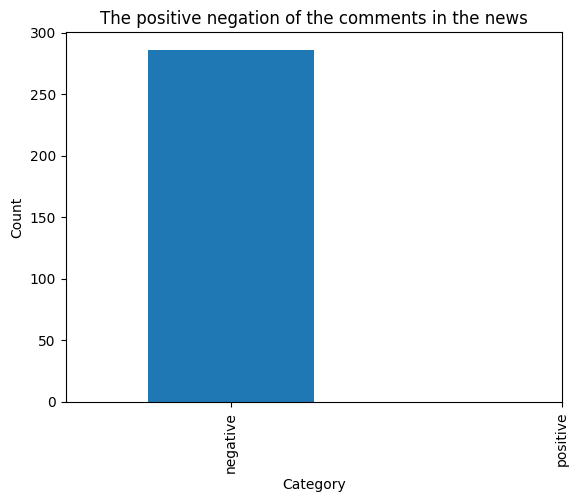

In [15]:
# 시각화
import matplotlib.pyplot as plt
import pandas as pd

print(df.shape)
df['reaction'].value_counts().plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('The positive negation of the comments in the news')
plt.xticks([0, 1], ['negative', 'positive']) 
plt.show()

In [16]:
# 수작업으로 모은 긍정적인 뉴스 댓글
a = """ "이 정책은 우리 사회에 필요한 변화를 가져올 것 같아요. 정말 기대됩니다."

"다양한 의견이 조화를 이루는 모습이 보기 좋습니다. 민주주의의 승리네요."

"이번 결정은 많은 사람들에게 긍정적인 영향을 미칠 것 같아요. 잘했어요!"

"정치인들이 이렇게 소통하고 협력하는 모습이 더 많아졌으면 좋겠어요."

"국민을 생각하는 따뜻한 정치, 앞으로도 계속 기대하겠습니다."

"정책의 이면까지 세심하게 살피는 모습에 박수를 보냅니다."

"국민을 위한 노력에 감사드려요. 앞으로도 좋은 활동 기대할게요."

"이번 법안은 정말 혁신적입니다. 미래가 더욱 기대되네요."

"정치의 진정한 목적을 실현하는 데 큰 도움이 될 것 같아요."

"국민 모두를 위한 정책, 정말 잘했다고 생각합니다."

"건전한 논의와 토론이 민주주의의 꽃입니다. 좋은 예가 되고 있어요."

"소통과 공감을 통한 정치, 정말 시급했던 변화였습니다."

"정치인들의 이런 모습을 보니 희망이 생깁니다."

"국민을 위한 진심이 느껴지는 정책이네요. 지지합니다!"

"민주주의가 한 걸음 더 성숙해가는 모습이 보기 좋습니다."

"서로 다른 의견을 존중하며 발전하는 모습이 인상적이에요."

"이런 변화가 우리 사회에 긍정적인 에너지를 가져다 줄 것 같아요."

"정치인들의 진정성 있는 노력에 박수를 보냅니다."

"국민을 생각하는 따뜻한 마음이 느껴집니다."

"이런 모습이야말로 진정한 리더십이라고 생각해요."

"정책의 방향이 바람직합니다. 앞으로의 변화가 기대되네요."

"정치가 국민의 목소리에 귀 기울이는 모습, 정말 중요합니다."

"투명하고 공정한 접근에 감사의 마음을 전합니다."

"국민의 삶을 개선하기 위한 노력이 보여서 좋습니다."

"사회적 약자를 위한 정책에 큰 박수를 보냅니다."

"이번 조치로 많은 사람들이 혜택을 받을 수 있을 것 같아요."

"국민을 위한 진심이 담긴 정책, 항상 응원하겠습니다."

"정치인들의 책임감 있는 행동에 깊은 인상을 받았습니다."

"이런 긍정적인 변화가 계속되길 바랍니다."

"정치가 올바른 방향으로 나아가고 있어 기쁩니다."

"국민의 입장을 고려한 정책이 많아져서 정말 다행입니다."

"정치인들의 이런 노력이 국민에게 희망을 줍니다."

"국민 모두의 의견이 반영된 정책에 감사드립니다."

"더 나은 사회를 위한 한걸음, 큰 의미가 있어요."

"공정하고 투명한 정치, 앞으로도 이어지길 바랍니다."

"모두가 함께하는 사회를 만들기 위한 노력이 보기 좋습니다."

"이러한 결정이 더 많아져서 사회가 더욱 발전하길 바랍니다."

"정치인들의 긍정적인 노력에 감사의 말씀을 전합니다."

"국민을 생각하는 마음이 느껴져서 좋습니다."

"밝은 미래를 위한 준비, 훌륭한 결정이에요."

"경제 발전에 중요한 한 걸음이 될 것 같아요. 앞으로의 성장이 기대됩니다!"

"이번 정책은 경제적 공정성을 강화하는 좋은 방향으로 나아가고 있네요."

"지속 가능한 경제 성장을 위한 훌륭한 결정입니다. 밝은 미래가 보여요."

"중소기업에 대한 지원 확대는 정말 중요한 일이죠. 경제 다양성에 크게 기여할 것 같아요."

"혁신적인 기업들이 계속 성장하길 바랍니다. 경제에 긍정적인 영향을 미치고 있어요."

"이번 경제 정책은 국민들에게 큰 도움이 될 것 같습니다. 정말 기대되네요!"

"경제적 안정성을 위한 노력에 감사드립니다. 정부의 노력이 보여요."

"무역 증진을 위한 이번 조치가 경제에 활력을 불어넣을 것 같습니다."

"친환경적인 경제 성장은 미래를 위한 중요한 투자입니다. 지속 가능한 발전이 기대돼요."

"신기술 개발에 대한 지원이 경제에 새로운 동력이 될 것 같습니다."

"공정한 거래 환경 조성에 힘쓰는 모습이 인상적입니다. 경제가 더욱 투명해지길 바라요."

"소비자 권익 보호에 중점을 둔 이번 조치는 매우 긍정적인 변화입니다."

"경제 성장과 함께 사회적 가치도 중시하는 정책이 좋네요."

"일자리 창출을 위한 노력이 보여서 기쁩니다. 많은 사람들에게 기회가 되길 바랍니다."

"경제적 균형을 위해 노력하는 모습이 보기 좋습니다. 모두가 혜택을 받길 바라요."

"안정적인 경제 성장을 위한 정책들이 매우 고무적입니다."

"창의적인 아이디어가 경제를 이끄는 것을 보니 희망적이네요."

"다양한 산업의 발전이 경제에 긍정적인 영향을 미치고 있어요."

"이번 투자 확대가 경제에 새로운 활력소가 되길 기대합니다."

"경제적 안정성을 위한 정부의 노력에 감사합니다."

"글로벌 경제에 기여하는 한국의 역할이 자랑스럽습니다."

"고용 증가와 경제 성장이 동시에 이루어지고 있어서 기쁩니다."

"정부의 혁신적인 경제 전략이 효과를 보이고 있네요."

"경제적 평등을 향한 노력이 더 많은 사람들에게 혜택을 줄 것 같아요."

"소비자의 선택권이 강화되는 것은 매우 긍정적인 현상입니다."

"지역 경제가 활성화되는 모습이 보기 좋습니다. 지역 공동체에 큰 도움이 되고 있어요."

"녹색 경제로의 전환을 위한 이번 조치는 매우 시의적절합니다."

"농촌 경제의 활성화가 기쁩니다. 지역사회에 큰 힘이 될 거예요."

"지속 가능한 발전을 위한 정책이 기대 이상의 효과를 보여주고 있네요."

"경제 혁신을 위한 노력이 결과를 보이기 시작했습니다. 멋진 변화입니다."

"이번 경제 회복 조치가 국민들에게 큰 힘이 되길 바랍니다."

"경제적 안정과 성장을 위한 정부의 끊임없는 노력에 감사드립니다."

"기업과 소비자 모두에게 이익이 되는 정책이 좋습니다."

"경제적 다양성과 혁신이 돋보이는 한 해였습니다."

"경제를 위한 창의적인 아이디어가 넘쳐나서 기쁩니다."

"건강한 경제 생태계 조성을 위한 노력이 결실을 맺길 바랍니다."

"경제적 지속 가능성을 위한 이번 조치에 큰 기대를 걸고 있습니다."

"국민 경제에 긍정적인 변화가 계속되길 기대합니다."

"경제적 발전과 함께 사회적 책임을 다하는 기업들에게 박수를 보냅니다."

"이번 경제적 성공이 앞으로 더 큰 성장의 발판이 되길 바랍니다."

"이 사회적 이니셔티브는 정말 가치 있네요. 모두가 동참했으면 좋겠습니다."

"다양성과 포용성에 대한 이러한 노력은 우리 사회를 더욱 풍부하게 만듭니다."

"이번 조치는 공정하고 정의로운 사회로 나아가는 중요한 발걸음입니다."

"사회적 약자를 위한 정책에 큰 박수를 보냅니다. 이것이 진정한 진보죠."

"다문화 가정에 대한 지원 강화는 우리 사회의 다양성을 잘 보여줍니다."

"지역 사회 발전을 위한 이 프로젝트에 감사합니다. 모두에게 혜택이 돌아가길 바라요."

"사회적 기업을 지원하는 이번 조치는 정말 의미 있는 일입니다."

"이런 긍정적인 변화가 계속되길 바랍니다. 사회가 더욱 성숙해지고 있어요."

"사회적 책임을 실천하는 기업들이 늘어나서 좋습니다. 본보기가 되길 바라요."

"다양한 목소리에 귀 기울이는 것이 중요합니다. 좋은 논의가 기대돼요."

"우리 사회의 발전을 위해 힘쓰는 모든 이에게 감사합니다."

"평등하고 공정한 사회를 위한 노력에 박수를 보냅니다."

"이번 정책은 정말 혁신적이고 필요한 변화를 가져올 것 같습니다."

"사회적 포용과 다양성에 대한 이러한 접근은 매우 긍정적입니다."

"어려운 이웃을 돕는 이러한 움직임이 더 많아졌으면 좋겠습니다."

"이러한 사회적 노력이 우리 모두에게 희망을 줍니다."

"노인과 청소년을 위한 이 프로그램은 정말 중요합니다. 멋진 일이에요."

"지속 가능한 사회를 위한 이러한 결정에 감사드립니다."

"사회적 변화를 위해 노력하는 모든 분들에게 감사의 마음을 전합니다."

"이 사회적 이슈에 대한 적극적인 대응이 인상적입니다."

"환경 보호를 위한 이러한 노력이 바람직한 사회로의 길입니다."

"사회적 동등함을 위한 이번 조치는 매우 중요한 발걸음입니다."

"민주주의와 사회적 가치를 중시하는 이런 움직임이 좋습니다."

"모두를 위한 포용적인 사회를 만드는 데 기여하는 모든 이에게 감사합니다."

"공정하고 평등한 사회를 위한 노력이 보여서 기쁩니다."

"우리 사회가 더욱 성숙해지고 있는 것 같아요. 계속 이런 긍정적인 변화가 있길 바랍니다."

"사회적 연대와 협력이 더욱 강화되길 바랍니다. 함께라면 가능해요."

"사회적 문제에 대한 이러한 적극적인 해결책이 기대되네요."

"우리 사회가 더욱 정의롭고 평등하게 발전하길 바랍니다."

"이런 프로그램들이 사회적 불평등을 해소하는 데 도움이 되길 바랍니다."

"모두가 함께하는 사회를 만드는 것이 중요합니다. 좋은 예를 보여주셔서 감사합니다."

"사회적 포용과 다양성을 위한 이런 노력은 정말 필요합니다."

"이러한 긍정적인 사회적 변화가 계속되길 바랍니다."

"사회적 약자를 위한 이런 정책은 정말 중요해요. 많은 사람들에게 희망을 줍니다."

"다양한 계층의 목소리가 반영된 사회적 결정에 박수를 보냅니다."

"이러한 사회적 프로젝트가 많아져서 우리 사회가 더욱 발전하기를 바랍니다."

"사회적 책임을 다하는 기업과 개인에게 감사의 마음을 전합니다."

"모두를 위한 공정한 사회, 이렇게 되어가고 있어 기쁩니다."

"사회적 협력과 연대가 바로 우리가 나아가야 할 길입니다."

"사회적 문제 해결을 위한 이러한 노력이 계속되길 바랍니다."

"이런 문화 행사가 지역 사회에 활력을 불어넣어 주네요. 앞으로 더 많이 개최되길 바랍니다!"

"예술과 문화가 삶의 질을 향상시키는 데 큰 역할을 한다는 것을 다시 한번 느낍니다."

"다양한 문화의 조화로운 공존이 우리 사회를 더욱 풍부하게 만듭니다."

"지역 문화 예술가들을 지원하는 이런 노력은 정말 중요합니다."

"우리의 전통 문화를 잘 보존하고 발전시키는 모습이 보기 좋습니다."

"이런 행사를 통해 서로 다른 문화를 이해하는 좋은 기회가 되길 바랍니다."

"문화적 다양성을 존중하는 이런 활동이 더 확대되었으면 좋겠어요."

"공연 예술의 발전을 위한 지원이 더 많아지길 기대합니다."

"예술을 통해 사람들이 서로 연결되는 것이 멋집니다."

"지역 축제가 지역 경제에도 긍정적인 영향을 미칠 것 같네요."

"전통과 현대가 조화롭게 어우러진 이번 행사가 인상적입니다."

"다양한 문화 체험 활동이 사람들에게 새로운 영감을 줍니다."

"문화적 교류가 사회적 이해와 포용성을 높이는 데 중요한 역할을 하네요."

"아이들에게 다양한 문화 체험 기회를 제공하는 것이 정말 좋습니다."

"예술과 문화가 삶에 즐거움을 주는 소중한 원천임을 다시 한번 느낍니다."

"이런 문화 활동이 지역 사회에 활력을 불어넣는 듯합니다."

"문화적 다양성을 존중하고 확산하는 이러한 노력이 멋집니다."

"전통문화를 현대적으로 재해석하는 것이 매우 흥미롭네요."

"이번 전시회가 예술의 중요성을 다시 한번 일깨워줍니다."

"문화적 소통을 위한 이런 프로젝트가 더 많아졌으면 좋겠습니다."

"이런 축제가 지역 사회의 단합에 크게 기여하는 것 같아요."

"생활 속에서 예술을 접할 수 있는 기회가 더 많아져서 기쁩니다."

"다양한 문화의 아름다움을 발견하는 것이 정말 즐겁습니다."

"문화적 교류를 통해 서로를 더 잘 이해하게 되는 것 같아요."

"이런 행사가 사람들에게 새로운 시각을 제공합니다."

"문화와 예술이 우리의 일상에 행복을 가져다 줍니다."

"지역 문화 발전을 위한 이런 노력이 매우 긍정적입니다."

"이런 문화 행사가 우리 사회의 다양성과 창의성을 보여줍니다."

"문화 예술을 통해 새로운 경험을 하는 것이 정말 가치 있는 일이네요."

"이런 문화적 활동이 사람들의 삶을 더 풍요롭게 만듭니다."

"지역 사회와 문화 예술이 서로 상생하는 모습이 보기 좋습니다."

"문화 예술을 통한 교육의 중요성을 다시 한번 깨닫게 됩니다."

"문화적 다양성을 이해하고 존중하는 것이 중요합니다."

"생활 속의 예술이 우리에게 큰 기쁨과 영감을 줍니다."

"문화와 예술이 사회에 긍정적인 영향을 미친다는 것을 느낍니다."

"예술을 통해 사람들이 서로 소통하고 공감하는 것이 멋집니다."

"이런 문화 행사가 지역 사회에 활력을 주는 것 같아요."

"다양한 문화적 경험은 사람들을 더 넓은 세계로 인도합니다."

"예술과 문화가 우리의 일상을 더욱 풍요롭게 만듭니다."

"이런 문화적 활동이 사회적 유대를 강화하는 것 같아요."

"이 기술 발전이 우리 삶에 긍정적인 변화를 가져올 것 같아요. 정말 기대됩니다!"

"과학과 기술의 결합이 놀라운 결과를 만들어내고 있네요. 앞으로 더 많은 혁신이 기대됩니다."

"이런 혁신적인 발명품이 사회에 큰 도움이 될 것 같습니다. 창의력에 박수를 보냅니다."

"지속 가능한 기술 개발에 집중하는 모습이 인상적입니다. 미래를 위한 중요한 발걸음이에요."

"이러한 과학적 발견은 우리의 지식을 넓히는 데 큰 기여를 하고 있습니다."

"기술이 사람들의 삶을 더 편리하게 만드는 모습이 좋습니다. 계속해서 발전하길 바래요."

"환경을 보호하면서 기술적 진보를 이루는 것이 매우 중요합니다. 올바른 방향이네요."

"이번 연구가 더 많은 혁신적인 발전을 이끌어낼 것 같아요. 과학의 힘을 느낄 수 있네요."

"기술이 사회 문제를 해결하는 데 기여하는 것을 보니 희망적입니다."

"이런 기술적 진보가 우리 삶을 어떻게 변화시킬지 기대됩니다."

"과학과 기술이 만드는 미래가 더 밝아 보이네요."

"이러한 발명은 많은 사람들의 삶에 긍정적인 영향을 미칠 것 같아요."

"지속 가능한 발전을 위한 과학 기술의 노력에 감사드립니다."

"과학의 진보가 우리 사회를 더 발전시키고 있어요. 계속해서 좋은 결과가 나오길 바랍니다."

"이 기술이 실생활에 적용되면 많은 변화가 일어날 것 같아요. 기대가 큽니다."

"과학과 기술이 인류의 삶을 개선하는 데 큰 역할을 하고 있습니다."

"이런 혁신적인 기술 개발이 더 많이 이루어지길 바랍니다."

"과학적 연구가 사회에 긍정적인 영향을 미치는 것을 보니 기쁩니다."

"기술의 발전이 인류에게 더 많은 가능성을 열어주고 있네요."

"환경 친화적인 기술 개발에 주력하는 것이 중요합니다. 좋은 방향이에요."

"이 연구가 가져올 미래의 변화가 기대되네요."

"기술의 발전이 우리의 삶을 얼마나 변화시킬 수 있는지 보여주는 좋은 예입니다."

"지속 가능한 기술은 우리 모두에게 이익이 됩니다."

"과학과 기술의 발전이 이렇게 사회에 긍정적인 영향을 미치는 것을 보니 희망적이네요."

"이러한 기술 혁신이 더 많은 분야에서 일어나길 바랍니다."

"과학의 발전이 인류에게 큰 선물을 주고 있습니다."

"기술이 가져올 미래가 기대됩니다. 혁신적인 발전에 감사드려요."

"환경을 생각하는 지속 가능한 기술 개발에 박수를 보냅니다."

"기술과 과학이 만들어낸 이 혁신이 우리 삶을 어떻게 바꿀지 기대되네요."

"이러한 과학적 발견이 우리 사회에 긍정적인 영향을 미치길 바랍니다."

"기술의 힘으로 더 나은 세상을 만들어가는 것 같아요."

"과학과 기술이 우리 삶에 미치는 긍정적인 영향에 감사합니다."

"이번 발견이 우리 삶에 어떤 변화를 가져올지 기대됩니다."

"기술의 발전이 사회에 더 많은 편리함과 효율성을 가져다 줄 것 같아요."

"지속 가능한 기술 개발이 바로 우리가 나아가야 할 방향입니다."

"이런 기술 혁신이 더 많은 분야에 적용되길 기대합니다."

"과학적 발전이 우리의 미래를 밝게 만들고 있어요."

"이 기술이 가져올 사회적 변화가 기대되네요."

"과학과 기술의 결합이 만들어내는 놀라운 성과에 감탄합니다."

"기술이 우리 삶을 더욱 풍요롭고 편리하게 만들어주고 있어요."

"국제 협력을 통한 이러한 진전이 정말 고무적입니다. 세계 평화를 향한 큰 걸음이네요."

"세계 각국이 함께 노력하는 모습이 보기 좋습니다. 협력이야말로 진정한 해결책이죠."

"이러한 글로벌 이니셔티브가 세계적인 문제 해결에 큰 기여를 할 것 같습니다."

"다양한 문화의 교류가 더욱 활발해지길 바랍니다. 세계가 하나되는 느낌이에요."

"국제 사회의 도전과제에 대한 이러한 논의는 매우 중요합니다."

"세계적인 이슈에 대한 이런 관심이 더 많아지길 바랍니다. 모두가 함께 해결해야 해요."

"국제 평화와 안정을 위한 노력에 박수를 보냅니다."

"이번 협약이 세계 공동체에 큰 이익을 가져다 줄 것 같아 기쁩니다."

"세계적인 협력과 연대가 더욱 강화되길 바랍니다."

"이러한 국제적 노력이 지속되길 바랍니다. 글로벌 이슈 해결에 큰 도움이 될 거예요."

"세계의 다양한 목소리를 듣는 것이 중요합니다. 좋은 글로벌 커뮤니케이션이 이루어지길 바라요."

"지속 가능한 발전을 위한 국제적 노력에 감사합니다."

"세계 각국이 함께 협력하여 큰 문제를 해결하는 모습이 인상적입니다."

"문화적 다양성을 존중하는 글로벌 이니셔티브가 더 많아졌으면 좋겠어요."

"이번 국제 회담이 세계 평화와 번영에 크게 기여하기를 바랍니다."

"환경 문제에 대한 이러한 국제적 논의는 우리 모두에게 중요한 일입니다."

"세계 각국이 공동의 목표를 향해 나아가는 것이 보기 좋습니다."

"글로벌 이슈에 대한 국제적인 인식 향상이 기대됩니다."

"이러한 국제 협력이 더 많은 성과를 가져오길 바랍니다."

"세계적인 문제 해결을 위한 노력이 훌륭합니다. 앞으로도 계속되길 바래요."

"국제 커뮤니티의 연대가 세계적인 도전과제를 해결하는 열쇠입니다."

"이번 협약은 글로벌 공동체에 큰 이익이 될 것입니다."

"다른 문화와의 교류가 우리 사회에 긍정적인 영향을 미치고 있어요."

"세계 평화와 번영을 위한 이러한 움직임이 계속되길 바랍니다."

"국제적인 협력이 우리 모두에게 좋은 결과를 가져다 줄 것입니다."

"세계 각국의 노력이 모여 큰 변화를 만들어내고 있네요."

"이러한 글로벌 이니셔티브가 세계적인 문제 해결의 모범이 되길 바랍니다."

"세계 각국이 서로 협력하여 더 나은 미래를 만들어가고 있어요."

"글로벌 이슈에 대한 이런 노력이 정말 중요합니다."

"다른 국가들과의 협력을 통해 많은 것을 배울 수 있어요."

"국제 평화를 위한 이러한 노력에 감사드립니다."

"세계의 다양한 문화를 이해하는 것이 중요합니다. 문화 교류가 계속되길 바래요."

"글로벌 커뮤니티의 발전을 위해 노력하는 모든 이에게 감사합니다."

"이번 국제 회의가 세계적인 문제 해결에 큰 기여를 할 것 같아요."

"세계 공동체의 일원으로서 우리 모두가 함께 노력해야 합니다."

"글로벌 이슈에 대한 인식 향상이 매우 중요합니다."

"이러한 국제적 협력이 세계적인 도전과제를 해결하는 데 중요한 역할을 하고 있습니다."

"세계 각국의 문화를 이해하고 존중하는 것이 글로벌 사회의 중요한 부분입니다."

"이러한 국제적 노력이 세계 평화와 번영에 기여하기를 바랍니다."

"국제 사회가 함께 나아가는 모습이 희망적입니다. 더 많은 협력이 이루어지길 바래요." """

a = a.replace('\"', '').split('\n\n')
len(a)

240

In [17]:
import pandas as pd
df1 = pd.DataFrame({'comments': a, 'reaction': [1 for i in range(len(a))]})
df= pd.concat([df, df1], axis=0)
df.to_excel("comment_reaction.xlsx", index=False)

(526, 2)


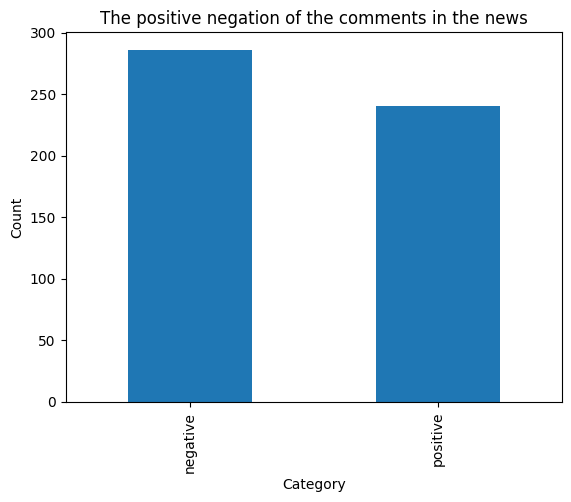

In [18]:
# 시각화
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_excel('comment_reaction.xlsx')
print(df.shape)
df['reaction'].value_counts().plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('The positive negation of the comments in the news')
plt.xticks([0, 1], ['negative', 'positive']) 
plt.show()

In [19]:
# 재사용을 위해 xlsX파일로 저장(뉴스 긍부정 판단 모델 데이터)
df.to_excel('comment_reaction.xlsx', index=False)
df.to_csv('comment_reaction.csv', index=None)

# 2. 뉴스제목 카테고리 분류 모델

### 2.0 라이브러리 임포트

In [20]:
import pandas as pd
import re
from bs4 import BeautifulSoup
import konlpy
import nltk
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import re
import pandas as pd

### 2.1 데이터 로드

In [21]:
df = pd.read_csv('train_data.csv')
print(df.shape)
df.head()

(45654, 3)


,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


### 2.2 데이터 전처리

In [22]:
# 필요없는 행 제거
df = df.drop(['index'], axis=1)
df.head()

,title,topic_idx
0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [23]:
# 결측치 확인 
# 있다면 삭제하지만, 현재 없음
df.isnull().sum()

title        0
topic_idx    0
dtype: int64

In [24]:
# 중복 제거
df.drop_duplicates(subset=['title'], inplace=True)

In [25]:
# 데이터 정제에 대한 함수
def clean_ko(df):
    # 첫 번째 칼럼의 이름을 가져옵니다.
    column_name = df.columns[0]

    # 텍스트 정제 (HTML 태그 제거)
    df[column_name] = df[column_name].apply(lambda x: BeautifulSoup(x, 'html.parser').text)

    # 텍스트 정제 (특수기호 제거)
    df[column_name] = df[column_name].apply(lambda x: re.sub(r'[^ ㄱ-ㅣ가-힣]', '', x))

    # 텍스트 정제 (형태소 분석)
    okt = konlpy.tag.Okt()
    def tokenize(text):
        return ' '.join([word[0] for word in okt.pos(text, stem=True) if word[1] in ['Noun', 'Verb', 'Adjective']])
    df[column_name] = df[column_name].apply(tokenize)

    # 텍스트 정제 (불용어 제거)
    nltk.download('punkt')
    stopwords_url = 'https://raw.githubusercontent.com/cranberryai/todak_todak_python/master/machine_learning_text/clean_korean_documents/korean_stopwords.txt'
    stopwords = pd.read_csv(stopwords_url, header=None)[0].apply(lambda x: x.strip()).to_list()
    df[column_name] = df[column_name].apply(lambda x: ' '.join([word for word in nltk.tokenize.word_tokenize(x) if word not in stopwords]))

    return df


In [26]:
# 데이터프레임속 데이터 정제
df = clean_ko(df)
df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jiwoossong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,title,topic_idx
0,인천 핀란드 항공기 결항 휴가 철 여행객 분통,4
1,실리콘밸리 넘어서다 구글 조원 들이다 전역 거점,4
2,이란 외무 긴장 완화 해결 책 미국 경제 전쟁 멈추다,4
3,클린턴 측근 기업 특수 관계 조명 공과 사 맞다 물리다 종합,4
4,시진핑 트럼프 중미 무역 협상 조속 타결 희망,4


In [27]:
# 학습셋과 테스트셋을 나눔
x_data = df['title']
y_data = df['topic_idx']
# 벡터화
transformer = TfidfVectorizer()
x_data_transformed = transformer.fit_transform(x_data)


# 학습 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(x_data_transformed, y_data, 
                                                    test_size=0.3, random_state=777, stratify=y_data)


### 2.3 모델 구축 및 모델 실행

In [28]:
# 다항 나이브 베이즈 모델 
model = MultinomialNB(alpha=1.0)
model.fit(X_train, y_train)

MultinomialNB()

### 2.4 모델 정확도와 모델 평가(F1스코어)

In [29]:
predict = model.predict(X_train)
print(f'Accuracy: {metrics.accuracy_score(y_train, predict)}')
print(f'F1 Score: {metrics.f1_score(y_train, predict, average=None)}')
print(f'label : {predict}')

Accuracy: 0.8893826078793379
F1 Score: [0.85412262 0.86636467 0.82467096 0.92111397 0.89306521 0.96511868
 0.89759666]
label : [6 0 4 ... 5 2 3]


In [30]:
# 모델 평가
predict = model.predict(X_test)
print(f'Accuracy: {metrics.accuracy_score(y_test, predict)}')
print(f'F1 Score: {metrics.f1_score(y_test, predict, average=None)}')
print(f'label : {predict}')

predict = model.predict_proba(X_test)
probability = predict[0][predict[0].argmax()]
print(f'probability : {probability}')

Accuracy: 0.8166751843469373
F1 Score: [0.77599143 0.79252238 0.7053511  0.85730858 0.81416309 0.94421834
 0.82586334]
label : [6 4 5 ... 5 3 0]
probability : 0.7614889339819371


### 2.5 예측 수행과 데이터 프레임 결합

In [31]:
import pandas as pd
labels = ['IT/과학', '경제', '사회', '생활/문화', '세계', '스포츠', '정치']
label_pre = []

# 새 CSV 파일 불러오기
new_data = pd.read_csv('newsdata.csv')

# 예측에 필요한 열 선택
selected_column = new_data.iloc[:, 0]  # 예를 들어 첫 번째 열 선택

# 전처리 수행
cleaned_data = clean_ko(pd.DataFrame(selected_column))

# 벡터화 수행
vectorized_data = transformer.transform(cleaned_data.iloc[:, 0])

# 예측 수행
predictions = model.predict(vectorized_data)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jiwoossong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [32]:
# 예측 결과 출력
for i in range(len(predictions)):
    label_pre.append(labels[predictions[i]])

print(label_pre)

['사회', '정치', '정치', '사회', '세계', '정치', '사회', '생활/문화', '사회', '사회', '사회', '생활/문화', '사회', '정치', '생활/문화', '사회', '정치', '세계', '정치', '세계', '사회', '정치', '경제', '생활/문화', '경제', '정치', '세계', '사회', '정치', '사회', '사회', '경제', '정치', '정치', '사회', '사회', '세계', '사회', '정치', '세계', '사회', '정치', '사회', '경제', '사회', '정치', '경제', '사회', '사회', '스포츠', '경제', '정치', '사회', '스포츠', '세계', '사회', '사회', '정치', '정치', '세계']


In [33]:
# 결과 확인
new_data['category'] = label_pre
new_data.head()

,title,link,comments,category
0,“통장 봤더니 200원”…붕어빵 ‘계좌이체’ 거부하는 사연 [잇슈 키워드],https://n.news.naver.com/article/056/001160421...,"['돈 없으면 먹지마라 서민들끼리 등쳐먹고 살면 좋냐? 다 어렵게 산다', '세상에...",사회
1,행정전산망 오류 이어 ‘정부24’도 중단…“오늘 복구 기다려봐야”,https://n.news.naver.com/article/056/001160454...,"['정부이길 포기한거냐?', '왜.....?', '윤석열 효과. 무엇을 상상하든 그...",정치
2,"러 매체 “한국 청년, 러시아군 자원입대해 실전 투입” [현장영상]",https://n.news.naver.com/article/056/001160441...,['본인의 의견은 존중하나 러시아 시민권 받으시면 한국국적은 포기해 주었으면 싶네요...,정치
3,배달된 쿠팡 상자서 살아 있는 쥐 나와…방역 업체가 포획,https://n.news.naver.com/article/056/001160463...,"['솔직히 저건 저 빌라에 서식하는 쥐가 틈새로 들어간거같은데ㅋㅋㅋ', '바쁜아침 ...",사회
4,“파리채로 내리쳐도 빈대가 죽을까?”…빈대 퇴치 행동요령 [오늘 이슈],https://n.news.naver.com/article/056/001160458...,"['눌러서 터지면 죽는거 아닌가', '빈대보고 어느세월에 스팀을 꺼내라고.... 걍...",세계


### 2.6 시각화(카테고리가 경제인 뉴스의 제목 워드클라우스 시각화)

In [34]:
# 특정 카테고리만 출력
sp_titles = new_data[new_data['category'] == '정치'] # 출력하고싶은 카테고리 입력

In [35]:
# 자신의 PC에 맞는 폰트 지정
import matplotlib.pyplot as plt
# 윈도우에서 한글 폰트 설정
# plt.rcParams['font.family'] = 'Malgun Gothic'

# 맥OS에서 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'

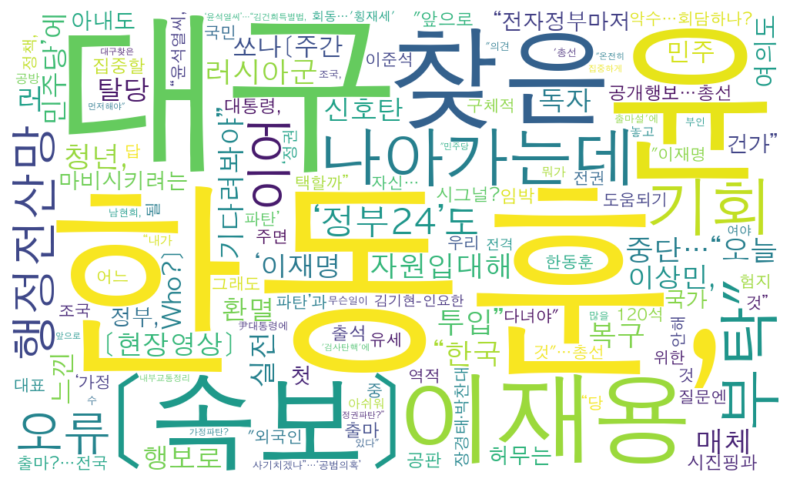

In [36]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd


# 모든 내용을 하나의 문자열로 합치기
text = ' '.join(sp_titles['title'])

# 단어의 빈도수 계산
words = text.split()
count = Counter(words)
data = dict(count)

# 윈도우
# font_path = 'C:/Windows/Fonts/malgun.ttf'
# 맥OS
font_path = '/System/Library/Fonts/Supplemental/AppleGothic.ttf'

# 워드클라우드 객체 생성
wc = WordCloud(font_path=font_path, background_color="white", width=1000, height=600)
wc_img = wc.generate_from_frequencies(data)

# 워드클라우드 이미지 표시
plt.figure(figsize=(10, 6))
plt.imshow(wc_img, interpolation='bilinear')
plt.axis('off')
plt.show()

### 2.7 재사용을 위해 저장

In [37]:
new_data.to_excel('newsdata_update1.xlsx', index=False)
new_data.to_csv('newsdata_update1.csv', index=False)

# 2. 뉴스제목 카테고리 분류 모델(LSTM + 어텐션 모델)
- 정확도가 낮게 나와 딥러닝을 이용하여 LSTM과 어텐선을 사용한 모델도 만들어보았습니다. 
- 앞선 모델과 이 모델 둘 중 하나를 사용하시면 됩니다.
- 데이터프레임 충돌 방지로 모두 주석처리해 놓겠습니다

### 2.0 라이브러리 임포트

In [38]:
# import pandas as pd
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.callbacks import EarlyStopping
# from attention import Attention
# import numpy as np
# import re
# import matplotlib.pyplot as plt
# from bs4 import BeautifulSoup
# import konlpy
# import nltk

### 2.1 데이터 로드

In [39]:
# # 데이터 불러오기
# df = pd.read_csv('train_data.csv')

### 2.2 데이터 전처리

In [40]:
# # 필요없는 행 제거
# df = df.drop(['index'], axis=1)
# df.head()

In [41]:
# # 결측치 확인
# df.isnull().sum()
# # 있다면 제거
# # df.drop_duplicates(subset=['title'], inplace=True)

In [42]:
# def clean_ko(df):
#     # 첫 번째 칼럼의 이름을 가져옵니다.
#     column_name = df.columns[0]

#     # 텍스트 정제 (HTML 태그 제거)
#     df[column_name] = df[column_name].apply(lambda x: BeautifulSoup(x, 'html.parser').text)

#     # 텍스트 정제 (특수기호 제거)
#     df[column_name] = df[column_name].apply(lambda x: re.sub(r'[^ ㄱ-ㅣ가-힣]', '', x))

#     # 텍스트 정제 (형태소 분석)
#     okt = konlpy.tag.Okt()
#     def tokenize(text):
#         return ' '.join([word[0] for word in okt.pos(text, stem=True) if word[1] in ['Noun', 'Verb', 'Adjective']])
#     df[column_name] = df[column_name].apply(tokenize)

#     # 텍스트 정제 (불용어 제거)
#     nltk.download('punkt')
#     stopwords_url = 'https://raw.githubusercontent.com/cranberryai/todak_todak_python/master/machine_learning_text/clean_korean_documents/korean_stopwords.txt'
#     stopwords = pd.read_csv(stopwords_url, header=None)[0].apply(lambda x: x.strip()).to_list()
#     df[column_name] = df[column_name].apply(lambda x: ' '.join([word for word in nltk.tokenize.word_tokenize(x) if word not in stopwords]))

#     return df

In [43]:
# df = clean_ko(df)
# # 토큰화 및 시퀀스 변환
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(df['title'])
# sequences = tokenizer.texts_to_sequences(df['title'])

# # 패딩 (모든 시퀀스를 동일한 길이로 만듦)
# max_sequence_length = max([len(seq) for seq in sequences])
# data = pad_sequences(sequences, maxlen=max_sequence_length)

# # 레이블을 원-핫 인코딩
# labels = to_categorical(df['topic_idx'])

# # 훈련 데이터와 테스트 데이터로 분리
# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

### 2.3 모델 구축

In [44]:
# # LSTM 모델 구축
# model = Sequential()
# model.add(Embedding(len(tokenizer.word_index) + 1, 100, input_length=max_sequence_length))
# model.add(Dropout(0.5))
# model.add(LSTM(128, return_sequences=True))
# model.add(Attention())
# model.add(Dropout(0.5))
# model.add(Dense(labels.shape[1], activation='softmax'))

# # 모델 컴파일
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

# # 모델 요약 출력
# model.summary()

### 2.4 모델 학습

In [45]:
# # 모델 학습
# history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test), 
#                     callbacks=[early_stopping_callback])
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f'Test Accuracy: {accuracy:.2f}')

### 2.5 loss 시각화

In [46]:
# # 학습셋과 테스트셋의 오차를 저장 
# y_vloss = history.history['val_loss']
# y_loss = history.history['loss']

# x_len = np.arange(len(y_loss))
# plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
# plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# plt.legend(loc='upper right')
# plt.grid()
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.show()

### 2.6 예측 수행과 데이터 프레임 결함

In [47]:
# import pandas as pd
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# import numpy as np

# label = ['IT/과학', '경제', '사회', '생활/문화', '세계', '스포츠', '정치']
# predict_label = []

# # 새로운 데이터 파일 경로
# new_data_file_path = 'newsdata.csv'

# # 새로운 데이터 불러오기
# new_df = pd.read_csv(new_data_file_path)

# # 새로운 데이터의 'title' 컬럼에 대한 시퀀스 생성
# new_sequences = tokenizer.texts_to_sequences(new_df['title'])
# new_data = pad_sequences(new_sequences, maxlen=max_sequence_length)

# # 모델을 사용하여 카테고리 예측
# predicted_categories = model.predict(new_data)
# predicted_category_indices = np.argmax(predicted_categories, axis=1)

# # 예측된 카테고리 인덱스를 실제 카테고리 이름으로 변환
# for i in range(len(predicted_category_indices)):
#     predict_label.append(label[predicted_category_indices[i]])

# # 예측 결과를 데이터프레임에 추가
# new_df['category'] = predict_label


시각화부분부터는 이전 모델과 동일해 생략했습니다.

# 3. 뉴스 댓글 긍정 부정 분류 모델

- 설치해야하는 파일 입니다.
- pip install gensim
- pip install transformers
- pip install torch==1.10
- conda install -c conda-forge ipywidgets
- conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch

### 3.0 라이브러리 임포트

In [48]:
from konlpy.tag import Okt
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
import re
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

### 3.1 데이터 로드

In [49]:
data = pd.read_excel('./comment_reaction.xlsx')
data['reaction'].value_counts(normalize = True)

reaction
0    0.543726
1    0.456274
Name: proportion, dtype: float64

### 3.2 데이터 전처리

In [50]:
# 1. 데이터 전처리
# 한국어 형태소 분석기 초기화
okt = Okt()

# 불용어 리스트 (예시)
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '을', '를', '으로', '한', '하다']

# 텍스트 전처리 함수
def preprocess_text(text):
    # 특수 문자 제거
    text = re.sub(r'[^가-힣\s]', '', text)
    # 형태소 분석
    tokenized = okt.morphs(text, stem=True)
    # 불용어 제거
    tokenized = [word for word in tokenized if word not in stopwords]
    return tokenized

# 전처리 적용
data['preprocessed'] = data['comments'].apply(preprocess_text)


In [51]:
# 2. 워드 임베딩
# Word2Vec 모델 생성 및 훈련
word2vec_model = Word2Vec(sentences=data['preprocessed'], vector_size=100, window=5, min_count=5, workers=4)

In [52]:
# 3. 트랜스포머 모델 구성
# 토크나이저 초기화
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [53]:
# Bert 모델 초기화
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
# 데이터 분할
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, valid_data = train_test_split(train_data, test_size=0.25)

In [55]:
class NewsDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            return_tensors='pt',
            truncation=True,
            padding='max_length',
            max_length=256
        )
        input_ids = inputs['input_ids'][0]
        attention_mask = inputs['attention_mask'][0]
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label)
        }

In [56]:
# 데이터셋 및 데이터 로더 준비
train_dataset = NewsDataset(train_data, tokenizer)
valid_dataset = NewsDataset(valid_data, tokenizer)
test_dataset = NewsDataset(test_data, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True) 
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [57]:
# 모델 학습 설정
optimizer = AdamW(model.parameters(), lr=1e-5)

/Users/jiwoossong/anaconda3/envs/deeplearn/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### 3.3 모델구축 및 실행

In [58]:
def train_model(model, train_loader, valid_loader):
    for epoch in range(3):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch}"):
            optimizer.zero_grad()
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # 검증
        model.eval()
        total_eval_accuracy = 0
        for batch in tqdm(valid_loader, desc="Validating"):
            with torch.no_grad():
                outputs = model(**batch)
                logits = outputs.logits
                predictions = torch.argmax(logits, dim=-1)
                accuracy = accuracy_score(batch['labels'].cpu(), predictions.cpu())
                total_eval_accuracy += accuracy

        print(f"Epoch {epoch}, Loss: {total_loss}, Validation Accuracy: {total_eval_accuracy / len(valid_loader)}")

# 모델 훈련
train_model(model, train_loader, valid_loader)

# 아래 에포크 진행도가 위젯으로 표현되며, 켰다 껐을 때 빨간글씨로 표시되지만 에러가 아닙니다.

Training Epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

Validating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 0, Loss: 15.468256749212742, Validation Accuracy: 0.9910714285714286


Training Epoch 1:   0%|          | 0/40 [00:00<?, ?it/s]

Validating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1, Loss: 2.220672281458974, Validation Accuracy: 0.9464285714285714


Training Epoch 2:   0%|          | 0/40 [00:00<?, ?it/s]

Validating:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2, Loss: 1.465693673118949, Validation Accuracy: 0.9910714285714286


### 3.4 모델 평가

In [59]:
# 모델을 평가 모드로 설정
model.eval()

# 성능 평가를 위한 변수 초기화
total_accuracy = 0
total_precision = 0
total_recall = 0
total_f1 = 0
total_examples = 0

# 테스트 데이터셋에 대한 예측 수행
for batch in test_loader:
    with torch.no_grad():
        outputs = model(**batch)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        # 실제 라벨과 비교하여 성능 계산
        labels = batch['labels'].cpu()
        predictions = predictions.cpu()
        accuracy = accuracy_score(labels, predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')

        # 총 성능 업데이트
        total_accuracy += accuracy * len(batch['input_ids'])
        total_precision += precision * len(batch['input_ids'])
        total_recall += recall * len(batch['input_ids'])
        total_f1 += f1 * len(batch['input_ids'])
        total_examples += len(batch['input_ids'])

# 평균 성능 계산
avg_accuracy = total_accuracy / total_examples
avg_precision = total_precision / total_examples
avg_recall = total_recall / total_examples
avg_f1 = total_f1 / total_examples

# 결과 출력
print(f"Test Accuracy: {avg_accuracy:.4f}")
print(f"Test Precision: {avg_precision:.4f}")
print(f"Test Recall: {avg_recall:.4f}")
print(f"Test F1 Score: {avg_f1:.4f}")


Test Accuracy: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1 Score: 1.0000


### 3.5 모델 저장

In [60]:
# 모델의 state_dict 저장
torch.save(model.state_dict(), "model.pth")

# 전체 모델 저장 (필요한 경우)
torch.save(model, "complete_model.pth")

### 3.6 예측 수행과 데이터 프레임 결함

In [61]:
def preprocess_comment(comment, tokenizer, max_length=256):
    # 토큰화 및 입력 형식에 맞게 변환
    inputs = tokenizer.encode_plus(
        comment,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    return inputs

# 댓글을 분류하는 함수
def classify_comment(comment, model, tokenizer):
    # 모델을 평가 모드로 설정
    model.eval()

    # 댓글 전처리
    inputs = preprocess_comment(comment, tokenizer)

    # 예측 수행
    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=1).item()

    # 결과 반환 (0: 부정, 1: 긍정)
    return "긍정" if prediction == 1 else "부정"

In [62]:
# 데이터 로드
import pandas as pd

df_news = pd.read_excel("newsdata_update1.xlsx")

In [63]:
#문자열을 리스트로 바꾸는 작업 실행
import ast
for i in range(len(df_news)):
    a = df_news['comments'][i]
    a = ast.literal_eval(a)
    df_news['comments'][i] = a

In [64]:
# 데이터 프레임 필요한 부분만 불러오기
newsdata = df_news['comments']

In [65]:
# 모델 학습 수행
pred_reaction = []

for i in range(len(newsdata)):
    temp_reaction = []
    for j in range(len(newsdata[i])):
        temp = classify_comment(newsdata[i][j], model, tokenizer)
        temp_reaction.append(temp)
    pred_reaction.append(temp_reaction)

In [66]:
# 결과 예시 값 출력
print(pred_reaction[0])
print(pred_reaction[0][0])

['부정', '부정', '부정', '부정', '부정']
부정


In [67]:
# 부정이 긍정보다 더 많으면 부정적인 뉴스로 구분
total_reaction = []
for i in range(len(pred_reaction)):
    if(pred_reaction[i].count('부정') > pred_reaction[i].count('긍정')):
        total_reaction.append('부정')
    else:
        total_reaction.append('긍정')

In [68]:
# 데이터 프레임 결합
df_news['reaction'] = total_reaction
df_news.head()

,title,link,comments,category,reaction
0,“통장 봤더니 200원”…붕어빵 ‘계좌이체’ 거부하는 사연 [잇슈 키워드],https://n.news.naver.com/article/056/001160421...,"[돈 없으면 먹지마라 서민들끼리 등쳐먹고 살면 좋냐? 다 어렵게 산다, 세상에 거지...",사회,부정
1,행정전산망 오류 이어 ‘정부24’도 중단…“오늘 복구 기다려봐야”,https://n.news.naver.com/article/056/001160454...,"[정부이길 포기한거냐?, 왜.....?, 윤석열 효과. 무엇을 상상하든 그 이상! ...",정치,부정
2,"러 매체 “한국 청년, 러시아군 자원입대해 실전 투입” [현장영상]",https://n.news.naver.com/article/056/001160441...,[본인의 의견은 존중하나 러시아 시민권 받으시면 한국국적은 포기해 주었으면 싶네요....,정치,부정
3,배달된 쿠팡 상자서 살아 있는 쥐 나와…방역 업체가 포획,https://n.news.naver.com/article/056/001160463...,"[솔직히 저건 저 빌라에 서식하는 쥐가 틈새로 들어간거같은데ㅋㅋㅋ, 바쁜아침 프레...",사회,부정
4,“파리채로 내리쳐도 빈대가 죽을까?”…빈대 퇴치 행동요령 [오늘 이슈],https://n.news.naver.com/article/056/001160458...,"[눌러서 터지면 죽는거 아닌가, 빈대보고 어느세월에 스팀을 꺼내라고.... 걍 스카...",세계,부정


### 3.7 시각화(카테고리: 정치, 반응: 부정적인 뉴스 워드클라우드 시각화)

In [69]:
# 카테고리 선택
sp_titles = df_news[(df_news['category'] == '경제') & (df_news['reaction'] == '부정')]

In [70]:
# 자신의 PC에 맞는 폰트 지정
import matplotlib.pyplot as plt

# 윈도우에서 한글 폰트 설정
# plt.rcParams['font.family'] = 'Malgun Gothic'

# 맥OS에서 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'

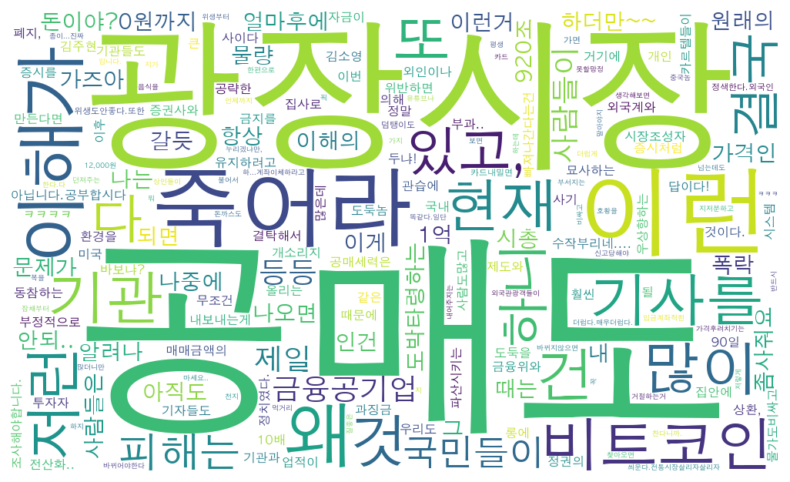

In [71]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

text = ' '.join([' '.join(inner_list) for inner_list in sp_titles['comments']])

# 단어의 빈도수 계산
words = text.split()
count = Counter(words)
data = dict(count)

# 윈도우
# font_path = 'C:/Windows/Fonts/malgun.ttf' 
font_path = '/System/Library/Fonts/Supplemental/AppleGothic.ttf'

# 워드클라우드 객체 생성
wc = WordCloud(font_path=font_path, background_color="white", width=1000, height=600)
wc_img = wc.generate_from_frequencies(data)

# 워드클라우드 이미지 표시
plt.figure(figsize=(10, 6))
plt.imshow(wc_img, interpolation='bilinear')
plt.axis('off')
plt.show()

### 최종 데이터 프레임 저장

In [72]:
# 필요없는 행 제거
df_news = df_news.drop(['comments'], axis=1)

In [73]:
# 확인
df_news.head()

,title,link,category,reaction
0,“통장 봤더니 200원”…붕어빵 ‘계좌이체’ 거부하는 사연 [잇슈 키워드],https://n.news.naver.com/article/056/001160421...,사회,부정
1,행정전산망 오류 이어 ‘정부24’도 중단…“오늘 복구 기다려봐야”,https://n.news.naver.com/article/056/001160454...,정치,부정
2,"러 매체 “한국 청년, 러시아군 자원입대해 실전 투입” [현장영상]",https://n.news.naver.com/article/056/001160441...,정치,부정
3,배달된 쿠팡 상자서 살아 있는 쥐 나와…방역 업체가 포획,https://n.news.naver.com/article/056/001160463...,사회,부정
4,“파리채로 내리쳐도 빈대가 죽을까?”…빈대 퇴치 행동요령 [오늘 이슈],https://n.news.naver.com/article/056/001160458...,세계,부정


In [74]:
# 최종 결과 출력
df_news.to_csv('final.csv', index=False)
df_news.to_excel('final.xlsx', index=False)